In [ ]:
!pip install opencv-python numpy tensorflow scikit-learn matplotlib wandb tdqm wurlitzer pandas plotly pyarrow

In [2]:
import os
import math
import pandas as pd
import numpy as np
#Load parquet data into dataset_parquet for training.
import tensorflow as tf
from tensorflow import keras
from keras.regularizers import l2
from glob import glob
from tqdm import tqdm
from collections import Counter
import random
import time
import wandb

2024-04-23 01:04:41.595028: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 01:04:41.595071: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 01:04:41.595095: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-23 01:04:41.602772: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
class CONFIG:
    # root = os.path.join("/", "kaggle", "input", "asl-signs") 
    # root = os.path.join(".")
    root = os.path.join(".")
    #root = os.path.join("..", "data", "asl-signs")
    DATA_LIMIT = 2000
    BATCH_SIZE = 32
    VIDEO_LENGTH = 36
    TRAIN_VAL_SPLIT = 0.8
    WANDB_RUN = "mediapipe-asl-dataset"


In [8]:
LIPS_IDXS0 = np.array([
        61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
        291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
        78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
        95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
    ])


EYE_LEFT = np.array([33, 7, 246, 161, 160, 159, 158, 157, 173, 133, 155, 154, 153, 145, 144, 163, 471, 470, 469, 472])


EYE_RIGHT = np.array([362, 398, 384, 385, 386, 387, 388, 466, 263, 249, 390, 373, 374, 380, 381, 382, 476, 475, 474, 477])
# Landmark indices in original data
LEFT_HAND_IDXS0 = np.arange(468,489)
RIGHT_HAND_IDXS0 = np.arange(522,543)
LEFT_POSE_IDXS0 = np.array([502, 504, 506, 508, 510])
RIGHT_POSE_IDXS0 = np.array([503, 505, 507, 509, 511])


LIPS_END = len(LIPS_IDXS0)
EYE_LEFT_END = LIPS_END + len(EYE_LEFT)
EYE_RIGHT_END = EYE_LEFT_END + len(EYE_RIGHT)
LEFT_HAND_END = EYE_RIGHT_END + len(LEFT_HAND_IDXS0)
RIGHT_HAND_END = LEFT_HAND_END + len(RIGHT_HAND_IDXS0)
LEFT_POSE_END = RIGHT_HAND_END + len(LEFT_POSE_IDXS0)
RIGHT_POSE_END = LEFT_POSE_END + len(RIGHT_POSE_IDXS0)

print("LIPS : ",len(LIPS_IDXS0))
print("EYE_LEFT : ",len(EYE_LEFT))
print("EYE_RIGHT : ",len(EYE_RIGHT))
print("LEFT_HAND : ",len(LEFT_HAND_IDXS0))
print("RIGHT_HAND : ",len(RIGHT_HAND_IDXS0))
print("LEFT_POSE : ",len(LEFT_POSE_IDXS0))
print("RIGHT_POSE : ",len(RIGHT_POSE_IDXS0))

all_selection = np.concatenate([LIPS_IDXS0, EYE_LEFT, EYE_RIGHT, LEFT_HAND_IDXS0, RIGHT_HAND_IDXS0, LEFT_POSE_IDXS0, RIGHT_POSE_IDXS0])
print(len(all_selection))

LIPS :  40
EYE_LEFT :  20
EYE_RIGHT :  20
LEFT_HAND :  21
RIGHT_HAND :  21
LEFT_POSE :  5
RIGHT_POSE :  5
132


In [9]:
def update_mean (values, mean, cnt):
    if np.any(np.isnan(values)):
        return mean, cnt
    
    mean += np.sum(values, axis=0)
    cnt += values.shape[0]
    return mean, cnt

def update_std(values, mean, std):
    if np.any(np.isnan(values)):
        return std
    
    std += np.sum((values - mean)**2, axis=0)
    return std

In [10]:
#this code sorts out a parquet files and rearrange the order to pose,face, left-hand, right-hand
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split
import plotly.io as pio

def visualize_keypoints(frames : np.ndarray, point_size : int):
    if len(frames.shape) == 1:
        frames = np.array([frames])
    
    for frame in frames:
        frame = frame.reshape(-1, 3)
        sizes = point_size * np.ones(frame.shape[0])

        fig = go.Figure(data=go.Scatter(x=frame[:,0], y=2.5 - frame[:,1], mode='markers',
                                        marker=dict(
                                            size=sizes
                                            )))

    # Customize the layout
    fig.update_layout(title='visualization of human keypoints',
                        xaxis_title='',
                        yaxis_title='',
                        width=1000,
                        height=1600)

    fig.update_xaxes(range=[-0.2, 1.4])  # Set x-axis range from 0 to 6
    fig.update_yaxes(range=[0, 2.5])  # Set y-axis range from 10 to 20

    # Show the plot
    fig.show()

def process_parquet2(ds, idxes = None):
    ret = []    
    frame_size = 543
    it = len(ds) // frame_size
    assert it == len(ds) / frame_size
    
    for i in range(it):
        vals = ds.iloc[ i * frame_size : (i + 1 ) * frame_size ]        
        
        if idxes is not None:          
            vals = ds.iloc[idxes]
                        
        ret.append(np.array(vals[["x","y", "z"]]))
        
    return np.array(np.array(ret))

In [78]:
class Groups:
    def __init__(self):
        self.starts = []
        self.id_2_label = {}
        self.means = []
        self.cnts = []
        self.stds = []

    def add(self, start, name):
        self.id_2_label[len(self.starts)] = name
        self.starts.append(start)
        self.means.append(np.array([0.0,0.0,0.0]))
        self.cnts.append(0)
        self.stds.append(np.array([0.0,0.0,0.0]))
        
    def reset(self):
        for i in range(len(self.means)):
            self.means[i] = np.array([0,0,0])
            self.cnts[i] = 0
            self.stds[i] = np.array([0,0,0])
            
    def __str__(self):
        s = ""
        for i in range(len(self.starts)):
            s += f"name={self.id_2_label[i]} idxes = ({self.starts[i][0]}, {self.starts[i][1]}), mu={self.means[i]}, std = {self.stds[i]}\n"
        
        return s
    
#custom class to load data from Parquet files for training ML models.
class ParquetDatasetCached(keras.utils.Sequence):
    def __init__(self, dataset_folder, csv_file : str, groups : Groups=None, batch_size=CONFIG.BATCH_SIZE, 
                 data_limit :int= CONFIG.DATA_LIMIT, check_if_file_exists = True, 
                 frame_length :int = CONFIG.VIDEO_LENGTH, split : str = "train", 
                 train_val_split : float = CONFIG.TRAIN_VAL_SPLIT, sort_by_counts : bool = True, 
                 idxes=None, **kwargs):
        super().__init__(**kwargs)
        #taking keras sequence for .fit(), .evaluate(), .predict() methods
        #load csv - it has the path to parquet file, and another to store label
        self.cached_Y = None
        self.cached_X = None
        self.csv_path = csv_file
        self.root_folder = dataset_folder
        self.batch_size = batch_size
        #optional pre-processing function to the parquet files.
        self.group = groups
        
        self.csv_data = pd.read_csv(self.csv_path)
        
        self.all_files = []
        self.not_exists = []
        self.frame_length = frame_length

        for path, label in tqdm(list(zip(self.csv_data["path"], self.csv_data["sign"]))):
            prop_path = os.path.join(self.root_folder, path)
            
            if check_if_file_exists:
                if os.path.exists(prop_path):
                    self.all_files.append((prop_path, label))
                else:
                    self.not_exists.append(prop_path)
            else:
                self.all_files.append((prop_path, label))
                
                    
        self.all_files = np.array(self.all_files)
        self.unique_labels = np.unique(self.all_files[:, 1])
        self.label_2_id = { key : i for i, key in enumerate(self.unique_labels)}
    
        # sort the values by popularity
        if sort_by_counts:
            cnt = Counter(self.all_files[:, 1])
            vals = []
            
            for i,row in enumerate(self.all_files):
                vals.append((int(1e6 * cnt[row[1]] + self.label_2_id [row[1]]),i))
            
            vals = np.array(sorted(vals)[::-1])
            self.all_files = self.all_files[vals[:,1]]

        
        if data_limit < 0:
            train_ds, val_ds = train_test_split(self.all_files, train_size=train_val_split, random_state=42)
        else:
            train_ds, val_ds = train_test_split(self.all_files[:data_limit], train_size=train_val_split, random_state=42)
            self.unique_labels = np.unique(self.all_files[:data_limit, 1])
            self.label_2_id = { key : i for i, key in enumerate(self.unique_labels)}
            
        if split.lower() == "train":
            self.dataset = train_ds
            
        elif split.lower() == "val":
            self.dataset = val_ds 
            
        else:
            raise Exception("please specify split to be either train or val")
            
        self.cache_data(idxes)
        self.calculate_props_for_groups()

    def normalize_data_points(self):
        for i in tqdm(range(len(self.cached_X)), desc="normalizing"):
            self.preprocess(self.cached_X[i])
            
                   
    def getGroups(self):
        return self.group
    
    def select(self, frames):
        current_length, num_features, _ = frames.shape
    
        if current_length >= CONFIG.VIDEO_LENGTH:
                # TODO: a better than uniform value ? Could place gaussian in the middle
                random_start = random.randint(0, current_length - CONFIG.VIDEO_LENGTH)
                return frames[random_start : (random_start + CONFIG.VIDEO_LENGTH)]
            
        # padd the video to contain zeros 
        return np.concatenate([frames, np.zeros((CONFIG.VIDEO_LENGTH - current_length, num_features,3))], axis=0)

    def preprocess(self, raw_frames):
        select_frames = raw_frames
        t = select_frames.shape[0]
        
        for i in range(t):   
            for j in range(len(self.group.starts)):
                start = self.group.starts[j] 
                mean, std = self.group.means[j], self.group.stds[j]
                region = select_frames[i, start[0] : start[1], :]                
                region = (region - mean) / std
                region = np.nan_to_num(region)                
                select_frames[i, start[0] : start[1]] = region
                
                
        return select_frames
        
            
    def cache_data(self, idxes):
        self.cached_X, self.cached_Y = [], []
        
        pb = tqdm(range(len(self.dataset)), desc="Cacheing")

        for i in pb:
            
            path, label = self.dataset[i]
            df = pd.read_parquet(path)
                        
            one_hot_encoded_label = np.zeros(len(self.unique_labels))
            one_hot_encoded_label[self.label_2_id[label]] = 1

            self.cached_X.append(process_parquet2(df, idxes=idxes))
            self.cached_Y.append(one_hot_encoded_label)     
            
        
    def calculate_props_for_groups(self):
        
        if self.group is None:
            return 
                            
        for frames in tqdm(self.cached_X, desc="calculating means"):
            for frame in frames:
                for i in range(len(self.group.starts)):
                    start = self.group.starts[i]
                    mean = self.group.means[i]
                    cnts = self.group.cnts[i]
                    
                    feature = frame[start[0]:start[1]]
                    
                    self.group.means[i], self.group.cnts[i] = update_mean(feature, mean, cnts)                   
 
        
        # set the means 
        for i in range(len(self.group.starts)):            
            self.group.means[i] = self.group.means[i] / self.group.cnts[i]
            
        # calculate the standard deviations
        for frames in tqdm(self.cached_X, desc="calculating std"):
            for frame in frames:
                for i in range(len(self.group.starts)):
                    start = self.group.starts[i]
                    std = self.group.stds[i]
                    mean = self.group.means[i]                    
                    feature = frame[start[0]:start[1]]
                    
                    self.group.stds[i] = update_std(feature, mean=mean, std=std)                   
 
        # set the standard deviations 
        for i in range(len(self.group.starts)):            
            self.group.stds[i] = np.sqrt(self.group.stds[i] / self.group.cnts[i])
  
    def set_group(self, group):
        self.group = group

    def __len__(self):
        # Assuming each Parquet file should be one batch; adjust if necessary
        return len(self.dataset)

    def __getitem__(self, idx):
        traj = self.select(self.cached_X[idx])
        t = traj.shape[0]
        return traj.reshape(t, -1), self.cached_Y[idx]                
        
    def on_epoch_end(self):
        # Shuffle files for the next epoch
        np.random.shuffle(self.dataset)


    
groups = Groups()
groups.add((0, LIPS_END), "lips")
groups.add((LIPS_END, EYE_LEFT_END), "left eye")
groups.add((EYE_LEFT_END, EYE_RIGHT_END), "right eye")
groups.add((EYE_RIGHT_END, LEFT_HAND_END), "left hand")
groups.add((LEFT_HAND_END, RIGHT_HAND_END), "right hand")
groups.add((RIGHT_HAND_END, LEFT_POSE_END), "left pose")
groups.add((LEFT_POSE_END, RIGHT_POSE_END), "right pose")

# Usage example
parquet_folder_path = CONFIG.root
train_dataset_parquet = ParquetDatasetCached(parquet_folder_path, csv_file = os.path.join(CONFIG.root, "train.csv"), 
                                 batch_size=CONFIG.BATCH_SIZE, data_limit=CONFIG.DATA_LIMIT, groups=groups,
                                             check_if_file_exists = False,
                                             split="train", idxes= all_selection)
train_dataset_parquet.normalize_data_points()

val_dataset_parquet = ParquetDatasetCached(parquet_folder_path, csv_file = os.path.join(CONFIG.root, "train.csv"), 
                                 batch_size=CONFIG.BATCH_SIZE, data_limit=CONFIG.DATA_LIMIT,
                                 check_if_file_exists= False,
                                 split="val",idxes= all_selection)
val_dataset_parquet.set_group(train_dataset_parquet.group)
val_dataset_parquet.normalize_data_points()

print(f"cardinality of train : {len(train_dataset_parquet)}, cardinality of validation : {len(val_dataset_parquet)}")

normalizing: 100%|██████████| 400/400 [00:01<00:00, 257.56it/s]

cardinality of train : 1600, cardinality of validation : 400


In [79]:
print(groups)

name=lips idxes = (0, 40), mu=[ 0.46837713  0.48302917 -0.02288619], std = [0.07567185 0.07805494 0.01595569]
name=left eye idxes = (40, 60), mu=[0.3991533  0.42728534 0.00753501], std = [0.13361506 0.14249471 0.03310135]
name=right eye idxes = (60, 80), mu=[ 0.51717346  0.40728644 -0.00183984], std = [0.09961183 0.13192261 0.04502668]
name=left hand idxes = (80, 101), mu=[ 0.64549218  0.60715568 -0.05593578], std = [0.15745084 0.19082723 0.06481537]
name=right hand idxes = (101, 122), mu=[ 0.32559969  0.59123747 -0.06171813], std = [0.14304286 0.17530013 0.05818096]
name=left pose idxes = (122, 127), mu=[ 0.87917387  0.94527561 -1.30689645], std = [0.18371726 0.28708228 0.70052876]
name=right pose idxes = (127, 132), mu=[ 0.1245269   0.93955634 -1.58225958], std = [0.17150104 0.3138634  0.96991489]



In [80]:
nans = False

for x, y in tqdm(train_dataset_parquet):
    nans |= np.any(np.isnan(x))
    if nans:
        print("SAD : ")
        break

for x, y in tqdm(val_dataset_parquet):
    nans |= np.any(np.isnan(x))
    if nans:    
        print("SAD : ")
        break


100%|██████████| 400/400 [00:00<00:00, 55953.90it/s]


In [81]:
print(groups)

name=lips idxes = (0, 40), mu=[ 0.46837713  0.48302917 -0.02288619], std = [0.07567185 0.07805494 0.01595569]
name=left eye idxes = (40, 60), mu=[0.3991533  0.42728534 0.00753501], std = [0.13361506 0.14249471 0.03310135]
name=right eye idxes = (60, 80), mu=[ 0.51717346  0.40728644 -0.00183984], std = [0.09961183 0.13192261 0.04502668]
name=left hand idxes = (80, 101), mu=[ 0.64549218  0.60715568 -0.05593578], std = [0.15745084 0.19082723 0.06481537]
name=right hand idxes = (101, 122), mu=[ 0.32559969  0.59123747 -0.06171813], std = [0.14304286 0.17530013 0.05818096]
name=left pose idxes = (122, 127), mu=[ 0.87917387  0.94527561 -1.30689645], std = [0.18371726 0.28708228 0.70052876]
name=right pose idxes = (127, 132), mu=[ 0.1245269   0.93955634 -1.58225958], std = [0.17150104 0.3138634  0.96991489]



101 122 127
len(frames) = 35


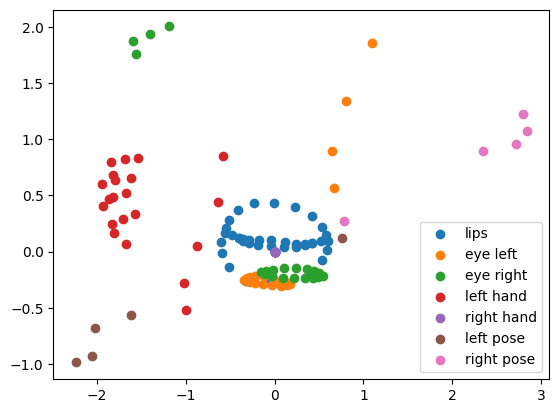

In [82]:
import matplotlib.pyplot as plt 

i = 1
LIPS_END = len(LIPS_IDXS0)
EYE_LEFT_END = LIPS_END + len(EYE_LEFT)
EYE_RIGHT_END = EYE_LEFT_END + len(EYE_RIGHT)
LEFT_HAND_END = EYE_RIGHT_END + len(LEFT_HAND_IDXS0)
RIGHT_HAND_END = LEFT_HAND_END + len(RIGHT_HAND_IDXS0)
LEFT_POSE_END = RIGHT_HAND_END + len(LEFT_POSE_IDXS0)
RIGHT_POSE_END = LEFT_POSE_END + len(RIGHT_POSE_IDXS0)

print(LEFT_HAND_END, RIGHT_HAND_END,LEFT_POSE_END)

frames = train_dataset_parquet.cached_X[i]
print(f"len(frames) = {len(frames)}")

frame = train_dataset_parquet.cached_X[0][0]

plt.scatter(frame[:LIPS_END, 0], frame[:LIPS_END, 1], label="lips")
plt.scatter(frame[LIPS_END:EYE_LEFT_END, 0], frame[LIPS_END:EYE_LEFT_END, 1], label="eye left")
plt.scatter(frame[EYE_LEFT_END:EYE_RIGHT_END,0], frame[EYE_LEFT_END:EYE_RIGHT_END, 1], label="eye right")
plt.scatter(frame[EYE_RIGHT_END:LEFT_HAND_END,0], frame[EYE_RIGHT_END:LEFT_HAND_END, 1], label="left hand")
plt.scatter(frame[LEFT_HAND_END:RIGHT_HAND_END, 0], frame[LEFT_HAND_END:RIGHT_HAND_END, 1], label="right hand")
plt.scatter(frame[RIGHT_HAND_END:LEFT_POSE_END, 0], frame[RIGHT_HAND_END:LEFT_POSE_END, 1], label="left pose")
plt.scatter(frame[LEFT_POSE_END:RIGHT_POSE_END, 0], frame[LEFT_POSE_END:RIGHT_POSE_END, 1], label="right pose")

plt.legend()
plt.show()

In [83]:
x, y = next(iter(train_dataset_parquet))
X_shape, Y_shape = x.shape, y.shape

In [84]:
x

array([[-0.55905635,  0.1629133 ,  1.03044723, ...,  2.72012163,
         0.95555742,  0.22947643],
       [-0.55905635,  0.1629133 ,  1.03044723, ...,  2.72012163,
         0.95555742,  0.22947643],
       [-0.55905635,  0.1629133 ,  1.03044723, ...,  2.72012163,
         0.95555742,  0.22947643],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [85]:
def dataset_train_generator():
    # Instantiate your existing dataset loader

    for i in range(len(train_dataset_parquet)):
        X_batch, Y_batch = train_dataset_parquet[i]
        yield X_batch, Y_batch
        
def dataset_val_generator():
    # Instantiate your existing dataset loader

    for i in range(len(val_dataset_parquet)):
        X_batch, Y_batch = val_dataset_parquet[i]
        yield X_batch, Y_batch        


train_dataset = tf.data.Dataset.from_generator(
    lambda: dataset_train_generator(),
    output_types=(tf.float32, tf.float32),  # Adjust types based on your actual data
    output_shapes=(X_shape, Y_shape)
).prefetch(tf.data.AUTOTUNE).batch(CONFIG.BATCH_SIZE)

val_dataset = tf.data.Dataset.from_generator(
    lambda: dataset_val_generator(),
    output_types=(tf.float32, tf.float32),  # Adjust types based on your actual data
    output_shapes=(X_shape, Y_shape)
).prefetch(tf.data.AUTOTUNE).batch(CONFIG.BATCH_SIZE)

In [86]:
els = np.array([0])
for x,y in tqdm(train_dataset):
    break 
    
x

0it [00:00, ?it/s]


<tf.Tensor: shape=(32, 36, 396), dtype=float32, numpy=
array([[[-0.55905634,  0.1629133 ,  1.0304472 , ...,  2.7201216 ,
          0.9555574 ,  0.22947644],
        [-0.55905634,  0.1629133 ,  1.0304472 , ...,  2.7201216 ,
          0.9555574 ,  0.22947644],
        [-0.55905634,  0.1629133 ,  1.0304472 , ...,  2.7201216 ,
          0.9555574 ,  0.22947644],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[-1.4844216 , -0.5923233 ,  1.0971457 , ..., -1.4787697 ,
          0.81079257,  0.04312035],
        [-1.4844216 , -0.5923233 ,  1.0971457 , ..., -1.4787697 ,
          0.81079257,  0.04312035],
        [-1.4844216 , -0.5923233 ,  1.0971457 , ..., -1.4787697 ,
          0.81079257,  0.04312035],
        ...,

20it [00:00, 97.44it/s]

(32, 36, 396) (32, 5)


50it [00:00, 100.54it/s]


Iterating through dataset took : 0.5006s


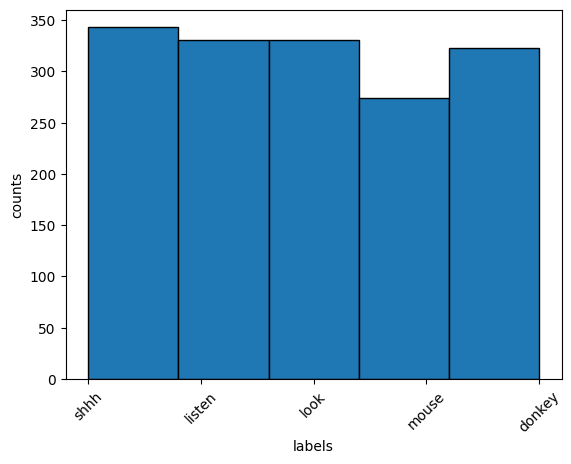

In [87]:
start = time.time()
isnans =False

id2label = {v : k for k,v in train_dataset_parquet.label_2_id.items()}

f = True
labels_batches = []
for el in tqdm(train_dataset):
    if f:
        print(el[0].shape, el[1].shape)
        f = False

    ls = np.argmax(el[1], axis=1)
    for l in ls:
        labels_batches.append(id2label[l])
    
    isnans |= np.any(np.isnan(el[0]))
    if isnans:
        print("FOUND NAN!")
        break

print(f"Iterating through dataset took : {round( time.time() - start , 4)}s")
plt.hist(labels_batches, bins=len(np.unique(labels_batches)), edgecolor="black")
plt.xlabel('labels')
plt.ylabel('counts')
plt.title('')

# Rotate x-axis ticks
plt.xticks(rotation=45)
plt.savefig("histogram.png")
plt.show()

In [88]:
from collections import defaultdict

c = defaultdict(list)
alltimes = []


for i in tqdm(range(len(train_dataset_parquet.cached_X))):
    x,y = train_dataset_parquet.cached_X[i], train_dataset_parquet.cached_Y[i]
    c[np.argmax(y)].append(x.shape[0])
    alltimes.append(x.shape[0])
    

100%|██████████| 1600/1600 [00:00<00:00, 269459.40it/s]


In [89]:
print(id2label)
no_cls = len(id2label)
fs = CONFIG.VIDEO_LENGTH

{0: 'donkey', 1: 'listen', 2: 'look', 3: 'mouse', 4: 'shhh'}


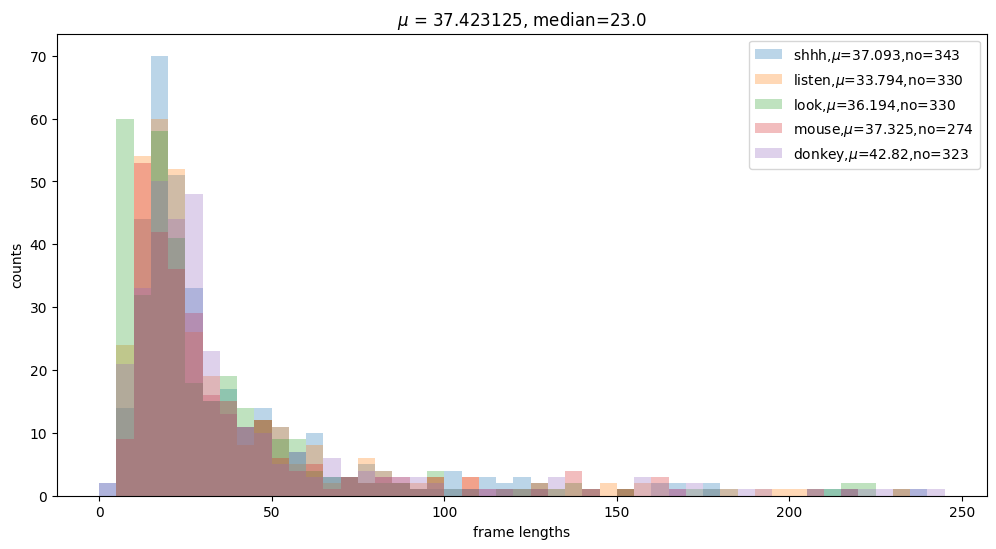

In [90]:

plt.figure(figsize=(12, 6))
ks = list(c.keys())

for k in ks:
    lengths = c[k]
    
    plt.title(f"$\mu$ = {np.mean(alltimes)}, median={np.median(alltimes)}")
    plt.hist(lengths, bins=np.arange(0, 250, 5), label=f"{id2label[k]},$\mu$={round(np.mean(lengths),3)},no={len(lengths)}", alpha=0.3)
    plt.xlabel("frame lengths")
    plt.ylabel("counts")


plt.legend()
plt.savefig("length distribution.png")
plt.show()

# Train experiment

In [91]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LeakyReLU
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import backend as K
from wandb.keras import WandbMetricsLogger
from keras.callbacks import Callback
import tensorflow as tf
import wandb


class CosineAnnealingLearningRateScheduler(Callback):
    def __init__(self, max_lr, min_lr, T_max):
        super(CosineAnnealingLearningRateScheduler, self).__init__()
        self.max_lr = max_lr  # Maximum learning rate (i.e., start learning rate)
        self.min_lr = min_lr  # Minimum learning rate
        self.T_max = T_max    # Specifies the number of epochs per cycle
        self.t = 0            # Current epoch

    def on_epoch_begin(self, epoch, logs=None):
        self.t += 1
        cos = np.cos(np.pi * (self.t % self.T_max) / self.T_max)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + cos)

        keras.backend.set_value(self.model.optimizer.lr, lr)

def keras_train(model, filepath : str, max_lr = 1e-4, min_lr = 5e-5, T_max=51, epochs=100, run_name="",
                mediapipe_features = "all", USE_WANDB=True): 
    
    
    checkpoint = keras.callbacks.ModelCheckpoint(filepath,
                                                 monitor="val_categorical_accuracy",
                                                 verbose=0,
                                                 save_best_only=True,
                                                 mode="max",
                                                 save_freq="epoch")
    
    cosine_annealer = CosineAnnealingLearningRateScheduler(max_lr=max_lr,
                                                           min_lr=min_lr,
                                                           T_max=T_max)
    
    #Adam Optimizer - fixed learning rate.
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=max_lr, weight_decay=1e-5, clipnorm=1.)

    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False,label_smoothing=0.2)
    model.compile(optimizer=adam_optimizer, loss=loss, metrics=['categorical_accuracy'])
    
    
    callbacks  = [checkpoint, cosine_annealer]
    
    if USE_WANDB:
        wandb.init(project=CONFIG.WANDB_RUN,
                        name=run_name,
                        notes="Model summary : \n" + str(model),
                        config={"max_lr" : max_lr, 
                                "min_lr" : 5e-5, 
                                "scheduler" : "cosineAnnealer", 
                                "epochs" : epochs, 
                                "T_max" : T_max, 
                                "train_size" : len(train_dataset_parquet.dataset),
                                "val_size" : len(val_dataset_parquet.dataset),
                                "unique_classes" : len(train_dataset_parquet.unique_labels), 
                                "video_length" : CONFIG.VIDEO_LENGTH,
                                "features" : mediapipe_features
                                })
        callbacks.append(WandbMetricsLogger())


    history = model.fit(train_dataset, epochs=epochs, validation_data = val_dataset, callbacks=callbacks)
    
    if USE_WANDB:      
        wandb.finish()
    
    return history

# LSTM

In [ ]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(16, return_sequences=False, input_shape=X_shape,
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", f"RK-LSTM16-LR-Dense256-fs={fs}-cls={no_cls}.tf"),
            run_name=f"RK-LSTM16-LR-Dense256-fs={fs}-cls={no_cls}",
            max_lr=1e-4,
            min_lr=2.5e-5,
            T_max=101,
            epochs=200,
            mediapipe_features="reduced-LipsEyesHandsPose-scaled",
            USE_WANDB=True)

epoch/categorical_accuracy,▁
epoch/epoch,▁
epoch/learning_rate,▁
epoch/loss,▁
epoch/val_categorical_accuracy,▁
epoch/val_loss,▁
epoch/categorical_accuracy,0.19187
epoch/epoch,0
epoch/learning_rate,0.0001
epoch/loss,1.61936
epoch/val_categorical_accuracy,0.2125


Epoch 1/200
     50/Unknown - 9s 146ms/step - loss: 1.6132 - categorical_accuracy: 0.2844

2024-04-23 01:11:50.667301: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14648368726491452287
2024-04-23 01:11:50.667405: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15650191045308210741
2024-04-23 01:11:50.667441: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 696204757222100644
2024-04-23 01:11:50.667461: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4945895755753639572
2024-04-23 01:11:52.799456: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16398769369169673559


INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


50/50 [==============================] - 13s 235ms/step - loss: 1.6132 - categorical_accuracy: 0.2844 - val_loss: 1.6060 - val_categorical_accuracy: 0.3200
Epoch 2/200
50/50 [==============================] - ETA: 0s - loss: 1.6000 - categorical_accuracy: 0.3487INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


50/50 [==============================] - 11s 226ms/step - loss: 1.6000 - categorical_accuracy: 0.3487 - val_loss: 1.5966 - val_categorical_accuracy: 0.3450
Epoch 3/200
50/50 [==============================] - ETA: 0s - loss: 1.5855 - categorical_accuracy: 0.3650INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


50/50 [==============================] - 12s 241ms/step - loss: 1.5855 - categorical_accuracy: 0.3650 - val_loss: 1.5789 - val_categorical_accuracy: 0.3675
Epoch 4/200
50/50 [==============================] - ETA: 0s - loss: 1.5638 - categorical_accuracy: 0.3719INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


50/50 [==============================] - 12s 235ms/step - loss: 1.5638 - categorical_accuracy: 0.3719 - val_loss: 1.5541 - val_categorical_accuracy: 0.4050
Epoch 5/200
50/50 [==============================] - ETA: 0s - loss: 1.5334 - categorical_accuracy: 0.3856INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


50/50 [==============================] - 12s 234ms/step - loss: 1.5334 - categorical_accuracy: 0.3856 - val_loss: 1.5278 - val_categorical_accuracy: 0.4275
Epoch 6/200
50/50 [==============================] - ETA: 0s - loss: 1.5007 - categorical_accuracy: 0.4081INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


50/50 [==============================] - 12s 233ms/step - loss: 1.5007 - categorical_accuracy: 0.4081 - val_loss: 1.4908 - val_categorical_accuracy: 0.4325
Epoch 7/200
50/50 [==============================] - ETA: 0s - loss: 1.4666 - categorical_accuracy: 0.4275INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


50/50 [==============================] - 11s 227ms/step - loss: 1.4666 - categorical_accuracy: 0.4275 - val_loss: 1.4632 - val_categorical_accuracy: 0.4625
Epoch 8/200
50/50 [==============================] - ETA: 0s - loss: 1.4372 - categorical_accuracy: 0.4519INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


50/50 [==============================] - 11s 229ms/step - loss: 1.4372 - categorical_accuracy: 0.4519 - val_loss: 1.4407 - val_categorical_accuracy: 0.4750
Epoch 9/200
50/50 [==============================] - 9s 185ms/step - loss: 1.4146 - categorical_accuracy: 0.4669 - val_loss: 1.4205 - val_categorical_accuracy: 0.4675
Epoch 10/200
33/50 [==================>...........] - ETA: 2s - loss: 1.3901 - categorical_accuracy: 0.4820

In [ ]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(32, return_sequences=False, input_shape=X_shape,
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models",          
            f"RK-LSTM32-LR-Dense256-fs={fs}-cls={no_cls}.tf"),
            run_name=f"RK-LSTM32-LR-Dense256-fs={fs}-cls={no_cls}",
            max_lr=1e-4,
            min_lr=2.5e-5,
            T_max=101,
            epochs=200,
            mediapipe_features="reduced-LipsEyesHandsPose-scaled",
            USE_WANDB=True)

In [ ]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(64, return_sequences=False, input_shape=X_shape,
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models",          
            f"RK-LSTM64-LR-Dense256-fs={fs}-cls={no_cls}.tf"),
            run_name=f"RK-LSTM64-LR-Dense256-fs={fs}-cls={no_cls}",
            max_lr=1e-4,
            min_lr=2.5e-5,
            T_max=101,
            epochs=200,
            mediapipe_features="reduced-LipsEyesHandsPose-scaled",
            USE_WANDB=True)

In [ ]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(128, return_sequences=False, input_shape=X_shape,
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models",          
            f"RK-LSTM128-LR-Dense256-fs={fs}-cls={no_cls}.tf"),
            run_name=f"RK-LSTM128-LR-Dense256-fs={fs}-cls={no_cls}",
            max_lr=1e-4,
            min_lr=2.5e-5,
            T_max=101,
            epochs=200,
            mediapipe_features="reduced-LipsEyesHandsPose-scaled",
            USE_WANDB=True)

In [ ]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(256, return_sequences=False, input_shape=X_shape,
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models",          
            f"RK-LSTM256-LR-Dense256-fs={fs}-cls={no_cls}.tf"),
            run_name=f"RK-LSTM256-LR-Dense256-fs={fs}-cls={no_cls}",
            max_lr=1e-4,
            min_lr=2.5e-5,
            T_max=101,
            epochs=200,
            mediapipe_features="reduced-LipsEyesHandsPose-scaled",
            USE_WANDB=True)

In [ ]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(512, return_sequences=False, input_shape=X_shape,
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models",          
            f"RK-LSTM512-LR-Dense256-fs={fs}-cls={no_cls}.tf"),
            run_name=f"RK-LSTM512-LR-Dense256-fs={fs}-cls={no_cls}",
            max_lr=1e-4,
            min_lr=2.5e-5,
            T_max=101,
            epochs=200,
            mediapipe_features="reduced-LipsEyesHandsPose-scaled",
            USE_WANDB=True)

In [77]:
X_shape

(36, 132, 3)

In [94]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(128, return_sequences=False, input_shape=X_shape,
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256, activation='gelu'))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())
model.add(Dense(128, activation='gelu'))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", f"RK-LSTM16-LR-Dense256-fs={fs}-cls={no_cls}.tf"),
            run_name=f"RK-LSTM16-LR-Dense256-fs={fs}-cls={no_cls}",
            max_lr=1e-4,
            min_lr=2.5e-5,
            T_max=101,
            epochs=200,
            mediapipe_features="reduced-LipsEyesHandsPose-scaled",
            USE_WANDB=True)

epoch/categorical_accuracy,▁▅▇█
epoch/epoch,▁▃▆█
epoch/learning_rate,█▇▄▁
epoch/loss,█▃▂▁
epoch/val_categorical_accuracy,▁▆▅█
epoch/val_loss,█▄▃▁
epoch/categorical_accuracy,0.63563
epoch/epoch,3
epoch/learning_rate,0.0003
epoch/loss,1.22607
epoch/val_categorical_accuracy,0.6525


Epoch 1/200
     48/Unknown - 3s 11ms/step - loss: 2.0469 - categorical_accuracy: 0.2357

2024-04-23 14:30:34.144196: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17038993016799033617
2024-04-23 14:30:34.144268: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4247586347779822691
2024-04-23 14:30:34.144283: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7516412549239084815
2024-04-23 14:30:34.144295: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6747532461201801410


INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


50/50 [==============================] - 7s 81ms/step - loss: 2.0396 - categorical_accuracy: 0.2375 - val_loss: 1.6596 - val_categorical_accuracy: 0.3400
Epoch 2/200
50/50 [==============================] - 1s 14ms/step - loss: 1.8184 - categorical_accuracy: 0.3056 - val_loss: 1.6765 - val_categorical_accuracy: 0.2975
Epoch 3/200
50/50 [==============================] - 1s 14ms/step - loss: 1.6903 - categorical_accuracy: 0.3656 - val_loss: 1.6918 - val_categorical_accuracy: 0.3075
Epoch 4/200
50/50 [==============================] - 1s 14ms/step - loss: 1.6862 - categorical_accuracy: 0.4069 - val_loss: 1.6945 - val_categorical_accuracy: 0.3300
Epoch 5/200
50/50 [==============================] - 1s 14ms/step - loss: 1.5860 - categorical_accuracy: 0.4525 - val_loss: 1.6825 - val_categorical_accuracy: 0.3400
Epoch 6/200
46/50 [==========================>...] - ETA: 0s - loss: 1.5341 - categorical_accuracy: 0.4626INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.

INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


50/50 [==============================] - 4s 73ms/step - loss: 1.5294 - categorical_accuracy: 0.4656 - val_loss: 1.6448 - val_categorical_accuracy: 0.3525
Epoch 7/200
46/50 [==========================>...] - ETA: 0s - loss: 1.4621 - categorical_accuracy: 0.5231INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


50/50 [==============================] - 3s 71ms/step - loss: 1.4632 - categorical_accuracy: 0.5250 - val_loss: 1.5936 - val_categorical_accuracy: 0.3700
Epoch 8/200
47/50 [===========================>..] - ETA: 0s - loss: 1.4356 - categorical_accuracy: 0.5379INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


50/50 [==============================] - 4s 71ms/step - loss: 1.4384 - categorical_accuracy: 0.5412 - val_loss: 1.5456 - val_categorical_accuracy: 0.4225
Epoch 9/200
47/50 [===========================>..] - ETA: 0s - loss: 1.3949 - categorical_accuracy: 0.5585INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


50/50 [==============================] - 4s 71ms/step - loss: 1.3942 - categorical_accuracy: 0.5619 - val_loss: 1.4927 - val_categorical_accuracy: 0.4375
Epoch 10/200
50/50 [==============================] - ETA: 0s - loss: 1.3667 - categorical_accuracy: 0.6056INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


50/50 [==============================] - 3s 70ms/step - loss: 1.3667 - categorical_accuracy: 0.6056 - val_loss: 1.4566 - val_categorical_accuracy: 0.4475
Epoch 11/200
46/50 [==========================>...] - ETA: 0s - loss: 1.3374 - categorical_accuracy: 0.6107INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


50/50 [==============================] - 5s 107ms/step - loss: 1.3359 - categorical_accuracy: 0.6112 - val_loss: 1.4186 - val_categorical_accuracy: 0.5000
Epoch 12/200
49/50 [============================>.] - ETA: 0s - loss: 1.3051 - categorical_accuracy: 0.6205INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


50/50 [==============================] - 3s 71ms/step - loss: 1.3056 - categorical_accuracy: 0.6212 - val_loss: 1.4010 - val_categorical_accuracy: 0.5250
Epoch 13/200
47/50 [===========================>..] - ETA: 0s - loss: 1.2947 - categorical_accuracy: 0.6456INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


50/50 [==============================] - 3s 69ms/step - loss: 1.2921 - categorical_accuracy: 0.6481 - val_loss: 1.3925 - val_categorical_accuracy: 0.5575
Epoch 14/200
45/50 [==========================>...] - ETA: 0s - loss: 1.2383 - categorical_accuracy: 0.6979INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


50/50 [==============================] - 4s 72ms/step - loss: 1.2448 - categorical_accuracy: 0.6975 - val_loss: 1.3797 - val_categorical_accuracy: 0.5850
Epoch 15/200
50/50 [==============================] - ETA: 0s - loss: 1.2505 - categorical_accuracy: 0.6669INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


50/50 [==============================] - 4s 71ms/step - loss: 1.2505 - categorical_accuracy: 0.6669 - val_loss: 1.3720 - val_categorical_accuracy: 0.5925
Epoch 16/200
45/50 [==========================>...] - ETA: 0s - loss: 1.2026 - categorical_accuracy: 0.7167INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


50/50 [==============================] - 4s 72ms/step - loss: 1.2025 - categorical_accuracy: 0.7181 - val_loss: 1.3822 - val_categorical_accuracy: 0.5975
Epoch 17/200
50/50 [==============================] - ETA: 0s - loss: 1.1926 - categorical_accuracy: 0.7306INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


50/50 [==============================] - 4s 71ms/step - loss: 1.1926 - categorical_accuracy: 0.7306 - val_loss: 1.3677 - val_categorical_accuracy: 0.6075
Epoch 18/200
50/50 [==============================] - 1s 14ms/step - loss: 1.1780 - categorical_accuracy: 0.7237 - val_loss: 1.3717 - val_categorical_accuracy: 0.6075
Epoch 19/200
50/50 [==============================] - ETA: 0s - loss: 1.1427 - categorical_accuracy: 0.7494INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


50/50 [==============================] - 5s 105ms/step - loss: 1.1427 - categorical_accuracy: 0.7494 - val_loss: 1.3696 - val_categorical_accuracy: 0.6175
Epoch 20/200
46/50 [==========================>...] - ETA: 0s - loss: 1.1343 - categorical_accuracy: 0.7731INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


50/50 [==============================] - 4s 71ms/step - loss: 1.1334 - categorical_accuracy: 0.7750 - val_loss: 1.3690 - val_categorical_accuracy: 0.6425
Epoch 21/200
50/50 [==============================] - 1s 15ms/step - loss: 1.1070 - categorical_accuracy: 0.7738 - val_loss: 1.3673 - val_categorical_accuracy: 0.6300
Epoch 22/200
50/50 [==============================] - 1s 15ms/step - loss: 1.0966 - categorical_accuracy: 0.7819 - val_loss: 1.3684 - val_categorical_accuracy: 0.6250
Epoch 23/200
50/50 [==============================] - 1s 15ms/step - loss: 1.0723 - categorical_accuracy: 0.8050 - val_loss: 1.3664 - val_categorical_accuracy: 0.6275
Epoch 24/200
50/50 [==============================] - 1s 15ms/step - loss: 1.0546 - categorical_accuracy: 0.8200 - val_loss: 1.3580 - val_categorical_accuracy: 0.6350
Epoch 25/200
50/50 [==============================] - 1s 14ms/step - loss: 1.0467 - categorical_accuracy: 0.8275 - val_loss: 1.3701 - val_categorical_accuracy: 0.6300
Epoch 26/20

INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


50/50 [==============================] - 4s 73ms/step - loss: 0.9941 - categorical_accuracy: 0.8644 - val_loss: 1.3656 - val_categorical_accuracy: 0.6475
Epoch 31/200
50/50 [==============================] - 1s 13ms/step - loss: 0.9933 - categorical_accuracy: 0.8637 - val_loss: 1.3455 - val_categorical_accuracy: 0.6375
Epoch 32/200
49/50 [============================>.] - ETA: 0s - loss: 0.9772 - categorical_accuracy: 0.8756INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


50/50 [==============================] - 4s 73ms/step - loss: 0.9771 - categorical_accuracy: 0.8763 - val_loss: 1.3474 - val_categorical_accuracy: 0.6525
Epoch 33/200
50/50 [==============================] - 1s 13ms/step - loss: 0.9669 - categorical_accuracy: 0.8825 - val_loss: 1.3467 - val_categorical_accuracy: 0.6525
Epoch 34/200
50/50 [==============================] - 1s 15ms/step - loss: 0.9566 - categorical_accuracy: 0.8863 - val_loss: 1.3347 - val_categorical_accuracy: 0.6375
Epoch 35/200
47/50 [===========================>..] - ETA: 0s - loss: 0.9590 - categorical_accuracy: 0.8836INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


50/50 [==============================] - 4s 71ms/step - loss: 0.9608 - categorical_accuracy: 0.8825 - val_loss: 1.3295 - val_categorical_accuracy: 0.6650
Epoch 36/200
50/50 [==============================] - 1s 13ms/step - loss: 0.9493 - categorical_accuracy: 0.9019 - val_loss: 1.3347 - val_categorical_accuracy: 0.6600
Epoch 37/200
49/50 [============================>.] - ETA: 0s - loss: 0.9473 - categorical_accuracy: 0.8935INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


50/50 [==============================] - 4s 72ms/step - loss: 0.9483 - categorical_accuracy: 0.8919 - val_loss: 1.3274 - val_categorical_accuracy: 0.6850
Epoch 38/200
50/50 [==============================] - 1s 14ms/step - loss: 0.9421 - categorical_accuracy: 0.8988 - val_loss: 1.3286 - val_categorical_accuracy: 0.6675
Epoch 39/200
50/50 [==============================] - 1s 15ms/step - loss: 0.9358 - categorical_accuracy: 0.8963 - val_loss: 1.3269 - val_categorical_accuracy: 0.6600
Epoch 40/200
50/50 [==============================] - 1s 14ms/step - loss: 0.9239 - categorical_accuracy: 0.9175 - val_loss: 1.3324 - val_categorical_accuracy: 0.6775
Epoch 41/200
50/50 [==============================] - 1s 15ms/step - loss: 0.9214 - categorical_accuracy: 0.9169 - val_loss: 1.3398 - val_categorical_accuracy: 0.6750
Epoch 42/200
50/50 [==============================] - 1s 15ms/step - loss: 0.9132 - categorical_accuracy: 0.9194 - val_loss: 1.3423 - val_categorical_accuracy: 0.6750
Epoch 43/20

INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


50/50 [==============================] - 3s 70ms/step - loss: 0.8179 - categorical_accuracy: 0.9750 - val_loss: 1.3371 - val_categorical_accuracy: 0.6875
Epoch 102/200
50/50 [==============================] - 1s 15ms/step - loss: 0.8219 - categorical_accuracy: 0.9744 - val_loss: 1.3656 - val_categorical_accuracy: 0.6525
Epoch 103/200
50/50 [==============================] - 1s 13ms/step - loss: 0.8200 - categorical_accuracy: 0.9781 - val_loss: 1.3199 - val_categorical_accuracy: 0.6800
Epoch 104/200
48/50 [===========================>..] - ETA: 0s - loss: 0.8153 - categorical_accuracy: 0.9759INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


50/50 [==============================] - 4s 72ms/step - loss: 0.8160 - categorical_accuracy: 0.9750 - val_loss: 1.3001 - val_categorical_accuracy: 0.7000
Epoch 105/200
50/50 [==============================] - 1s 14ms/step - loss: 0.8181 - categorical_accuracy: 0.9762 - val_loss: 1.3153 - val_categorical_accuracy: 0.6825
Epoch 106/200
50/50 [==============================] - 1s 15ms/step - loss: 0.8125 - categorical_accuracy: 0.9800 - val_loss: 1.3256 - val_categorical_accuracy: 0.6725
Epoch 107/200
50/50 [==============================] - 1s 13ms/step - loss: 0.8140 - categorical_accuracy: 0.9750 - val_loss: 1.3143 - val_categorical_accuracy: 0.6850
Epoch 108/200
50/50 [==============================] - 1s 14ms/step - loss: 0.8164 - categorical_accuracy: 0.9725 - val_loss: 1.3374 - val_categorical_accuracy: 0.6600
Epoch 109/200
50/50 [==============================] - 1s 14ms/step - loss: 0.8174 - categorical_accuracy: 0.9769 - val_loss: 1.3359 - val_categorical_accuracy: 0.6825
Epoch 

INFO:tensorflow:Assets written to: models/RK-LSTM16-LR-Dense256-fs=36-cls=5.tf/assets


50/50 [==============================] - 5s 109ms/step - loss: 0.7784 - categorical_accuracy: 0.9931 - val_loss: 1.2661 - val_categorical_accuracy: 0.7050
Epoch 132/200
50/50 [==============================] - 1s 15ms/step - loss: 0.7802 - categorical_accuracy: 0.9900 - val_loss: 1.3091 - val_categorical_accuracy: 0.6775
Epoch 133/200
50/50 [==============================] - 1s 14ms/step - loss: 0.7849 - categorical_accuracy: 0.9862 - val_loss: 1.3150 - val_categorical_accuracy: 0.6725
Epoch 134/200
50/50 [==============================] - 1s 15ms/step - loss: 0.7783 - categorical_accuracy: 0.9906 - val_loss: 1.2922 - val_categorical_accuracy: 0.6925
Epoch 135/200
50/50 [==============================] - 1s 15ms/step - loss: 0.7767 - categorical_accuracy: 0.9919 - val_loss: 1.2866 - val_categorical_accuracy: 0.6850
Epoch 136/200
50/50 [==============================] - 1s 14ms/step - loss: 0.7740 - categorical_accuracy: 0.9900 - val_loss: 1.2809 - val_categorical_accuracy: 0.6825
Epoch

epoch/categorical_accuracy,▁▃▄▅▆▆▇▇▇▇▇█████████████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,████▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁████▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁
epoch/loss,█▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▂▅▆▇▇▇▇████▇███████▇▇█▇▇█████▇▇████████
epoch/val_loss,█▇▃▃▃▃▃▂▂▂▃▂▂▂▃▂▃▂▂▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch/categorical_accuracy,0.99875
epoch/epoch,199
epoch/learning_rate,3e-05
epoch/loss,0.7455
epoch/val_categorical_accuracy,0.685


# GRU

In [ ]:
from tensorflow.keras import layers

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(layers.GRU(16, return_sequences=False, input_shape=X_shape,
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", f"RK-GRU16-LR-Dense256-gelu-fs={fs}-cls={no_cls}.tf"),
            run_name=f"RK-GRU16-LR-Dense256-gelu-fs={fs}-cls={no_cls}",
            max_lr=1e-4,
            min_lr=2.5e-5,
            T_max=101,
            epochs=200,
            mediapipe_features="reduced-LipsEyesHandsPose-scaled",
            USE_WANDB=True)

In [ ]:
from tensorflow.keras import layers

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(layers.GRU(32, return_sequences=False, input_shape=X_shape,
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", f"RK-GRU32-LR-Dense256-gelu-fs={fs}-cls={no_cls}.tf"),
            run_name=f"RK-GRU32-LR-Dense256-gelu-fs={fs}-cls={no_cls}",
            max_lr=1e-4,
            min_lr=2.5e-5,
            T_max=101,
            epochs=200,
            mediapipe_features="reduced-LipsEyesHandsPose-scaled",
            USE_WANDB=True)

In [ ]:
from tensorflow.keras import layers

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(layers.GRU(64, return_sequences=False, input_shape=X_shape,
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", f"RK-GRU64-LR-Dense256-gelu-fs={fs}-cls={no_cls}.tf"),
            run_name=f"RK-GRU64-LR-Dense256-gelu-fs={fs}-cls={no_cls}",
            max_lr=1e-4,
            min_lr=2.5e-5,
            T_max=101,
            epochs=200,
            mediapipe_features="reduced-LipsEyesHandsPose-scaled",
            USE_WANDB=True)

In [ ]:
from tensorflow.keras import layers

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(layers.GRU(128, return_sequences=False, input_shape=X_shape,
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", f"RK-GRU128-LR-Dense256-gelu-fs={fs}-cls={no_cls}.tf"),
            run_name=f"RK-GRU128-LR-Dense256-gelu-fs={fs}-cls={no_cls}",
            max_lr=1e-4,
            min_lr=2.5e-5,
            T_max=101,
            epochs=200,
            mediapipe_features="reduced-LipsEyesHandsPose-scaled",
            USE_WANDB=True)

In [ ]:
from tensorflow.keras import layers

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(layers.GRU(256, return_sequences=False, input_shape=X_shape,
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", f"RK-GRU256-LR-Dense256-gelu-fs={fs}-cls={no_cls}.tf"),
            run_name=f"RK-GRU256-LR-Dense256-gelu-fs={fs}-cls={no_cls}",
            max_lr=1e-4,
            min_lr=2.5e-5,
            T_max=101,
            epochs=200,
            mediapipe_features="reduced-LipsEyesHandsPose-scaled",
            USE_WANDB=True)

In [ ]:
from tensorflow.keras import layers

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(layers.GRU(512, return_sequences=False, input_shape=X_shape,
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", f"RK-GRU512-LR-Dense256-gelu-fs={fs}-cls={no_cls}.tf"),
            run_name=f"RK-GRU512-LR-Dense256-gelu-fs={fs}-cls={no_cls}",
            max_lr=1e-4,
            min_lr=2.5e-5,
            T_max=101,
            epochs=200,
            mediapipe_features="reduced-LipsEyesHandsPose-scaled",
            USE_WANDB=True)

## Bidirectional LSTM

In [ ]:
from tensorflow.keras import layers

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(layers.Bidirectional(LSTM(16, return_sequences=True, input_shape=X_shape,
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001))))
model.add(layers.Flatten())
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", f"RK-BLSTM16-LR-Dense256-gelu-fs={fs}-cls={no_cls}"),
            run_name=f"RK-BLSTM16-LR-Dense256-gelu-fs={fs}-cls={no_cls}",
            max_lr=1e-4,
            min_lr=2.5e-5,
            T_max=101,
            epochs=200,
            mediapipe_features="reduced-LipsEyesHandsPose-scaled",
            USE_WANDB=True)

In [ ]:
from tensorflow.keras import layers

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(layers.Bidirectional(LSTM(32, return_sequences=True, input_shape=X_shape,
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001))))
model.add(layers.Flatten())
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", f"RK-BLSTM32-LR-Dense256-gelu-fs={fs}-cls={no_cls}"),
            run_name=f"RK-BLSTM32-LR-Dense256-gelu-fs={fs}-cls={no_cls}",
            max_lr=1e-4,
            min_lr=2.5e-5,
            T_max=101,
            epochs=200,
            mediapipe_features="reduced-LipsEyesHandsPose-scaled",
            USE_WANDB=True)

In [ ]:
from tensorflow.keras import layers

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(layers.Bidirectional(LSTM(64, return_sequences=True, input_shape=X_shape,
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001))))
model.add(layers.Flatten())
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", f"RK-BLSTM64-LR-Dense256-gelu-fs={fs}-cls={no_cls}"),
            run_name=f"RK-BLSTM64-LR-Dense256-gelu-fs={fs}-cls={no_cls}",
            max_lr=1e-4,
            min_lr=2.5e-5,
            T_max=101,
            epochs=200,
            mediapipe_features="reduced-LipsEyesHandsPose-scaled",
            USE_WANDB=True)

In [ ]:
from tensorflow.keras import layers

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(layers.Bidirectional(LSTM(128, return_sequences=True, input_shape=X_shape,
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001))))
model.add(layers.Flatten())
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", f"RK-BLSTM128-LR-Dense256-gelu-fs={fs}-cls={no_cls}"),
            run_name=f"RK-BLSTM128-LR-Dense256-gelu-fs={fs}-cls={no_cls}",
            max_lr=1e-4,
            min_lr=2.5e-5,
            T_max=101,
            epochs=200,
            mediapipe_features="reduced-LipsEyesHandsPose-scaled",
            USE_WANDB=True)

In [ ]:
from tensorflow.keras import layers

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(layers.Bidirectional(LSTM(256, return_sequences=True, input_shape=X_shape,
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001))))
model.add(layers.Flatten())
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", f"RK-BLSTM256-LR-Dense256-gelu-fs={fs}-cls={no_cls}"),
            run_name=f"RK-BLSTM256-LR-Dense256-gelu-fs={fs}-cls={no_cls}",
            max_lr=1e-4,
            min_lr=2.5e-5,
            T_max=101,
            epochs=200,
            mediapipe_features="reduced-LipsEyesHandsPose-scaled",
            USE_WANDB=True)

## Bidirectional GRU

In [ ]:
from tensorflow.keras import layers

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(layers.Bidirectional(layers.GRU(16, return_sequences=True, input_shape=X_shape,
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001))))
model.add(layers.Flatten())
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", f"RK-BGRU16-LR-Dense256-gelu-fs={fs}-cls={no_cls}"),
            run_name=f"RK-BGRU16-LR-Dense256-gelu-fs={fs}-cls={no_cls}",
            max_lr=1e-4,
            min_lr=2.5e-5,
            T_max=101,
            epochs=200,
            mediapipe_features="reduced-LipsEyesHandsPose-scaled",
            USE_WANDB=True)

In [ ]:
from tensorflow.keras import layers

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(layers.Bidirectional(layers.GRU(32, return_sequences=True, input_shape=X_shape,
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001))))
model.add(layers.Flatten())
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", f"RK-BGRU32-LR-Dense256-gelu-fs={fs}-cls={no_cls}"),
            run_name=f"RK-BGRU32-LR-Dense256-gelu-fs={fs}-cls={no_cls}",
            max_lr=1e-4,
            min_lr=2.5e-5,
            T_max=101,
            epochs=200,
            mediapipe_features="reduced-LipsEyesHandsPose-scaled",
            USE_WANDB=True)

In [ ]:
from tensorflow.keras import layers

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(layers.Bidirectional(layers.GRU(64, return_sequences=True, input_shape=X_shape,
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001))))
model.add(layers.Flatten())
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", f"RK-BGRU64-LR-Dense256-gelu-fs={fs}-cls={no_cls}"),
            run_name=f"RK-BGRU64-LR-Dense256-gelu-fs={fs}-cls={no_cls}",
            max_lr=1e-4,
            min_lr=2.5e-5,
            T_max=101,
            epochs=200,
            mediapipe_features="reduced-LipsEyesHandsPose-scaled",
            USE_WANDB=True)

In [ ]:
from tensorflow.keras import layers

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(layers.Bidirectional(layers.GRU(128, return_sequences=True, input_shape=X_shape,
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001))))
model.add(layers.Flatten())
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", f"RK-BGRU128-LR-Dense256-gelu-fs={fs}-cls={no_cls}"),
            run_name=f"RK-BGRU128-LR-Dense256-gelu-fs={fs}-cls={no_cls}",
            max_lr=1e-4,
            min_lr=2.5e-5,
            T_max=101,
            epochs=200,
            mediapipe_features="reduced-LipsEyesHandsPose-scaled",
            USE_WANDB=True)

In [ ]:
from tensorflow.keras import layers

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(layers.Bidirectional(layers.GRU(256, return_sequences=True, input_shape=X_shape,
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001))))
model.add(layers.Flatten())
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", f"RK-BGRU256-LR-Dense256-gelu-fs={fs}-cls={no_cls}"),
            run_name=f"RK-BGRU256-LR-Dense256-gelu-fs={fs}-cls={no_cls}",
            max_lr=1e-4,
            min_lr=2.5e-5,
            T_max=101,
            epochs=200,
            mediapipe_features="reduced-LipsEyesHandsPose-scaled",
            USE_WANDB=True)

# Transformer

In [ ]:
X_shape = train_dataset_parquet[0][0].shape
Y_shape = train_dataset_parquet[0][1].shape
print(f"X_shape = {X_shape}, Y_shape = {Y_shape}")

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        return x + positions


In [ ]:
embed_dim = 128  # Embedding size for each token
num_heads = 4  # Number of attention heads
ff_dim = 256  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=X_shape)
embedding_layer = TokenAndPositionEmbedding(X_shape[0], X_shape[1])
x = embedding_layer(inputs)
transformer_block = TransformerBlock(X_shape[1], num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = Dense(len(train_dataset_parquet.unique_labels), activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

keras_train(model, filepath=os.path.join("models", f"Transformer-e={embed_dim}-h={num_heads}-ff={ff_dim}-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf"),
            run_name=f"Transformer-e={embed_dim}-h={num_heads}-ff={ff_dim}-D=0.1-Dense=128-LipsEyesHandsPose_5k",
                max_lr=1e-4,
            min_lr=2.5e-5,
            T_max=101,
            epochs=200,
            mediapipe_features="reduced-LipsEyesHandsPose-scaled",
            USE_WANDB=True)

In [ ]:
embed_dim = 128  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 128  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=X_shape)
embedding_layer = TokenAndPositionEmbedding(X_shape[0], X_shape[1])
x = embedding_layer(inputs)
transformer_block = TransformerBlock(X_shape[1], num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(128, activation="gelu")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(256, activation="gelu")(x)
x = layers.Dropout(0.1)(x)
outputs = Dense(len(train_dataset_parquet.unique_labels), activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

keras_train(model, filepath=os.path.join("models", f"Transformer-embed={embed_dim}-heads={num_heads}-ff={ff_dim}-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf"),
            run_name="Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k",
            mediapipe_features="reduced-LipsEyesHandsPose",
            T_max=151, epochs=300, 
            max_lr = 3e-4, min_lr = 5e-5,
            USE_WANDB=True)

In [ ]:
embed_dim = 64  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 128  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=X_shape)
embedding_layer = TokenAndPositionEmbedding(X_shape[0], X_shape[1])
x = embedding_layer(inputs)
transformer_block = TransformerBlock(X_shape[1], num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation="gelu")(x)
x = layers.Dropout(0.2)(x)
outputs = Dense(len(train_dataset_parquet.unique_labels), activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

keras_train(model, filepath=os.path.join("models", f"Transformer-embed={embed_dim}-heads={num_heads}-ff={ff_dim}-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf"),
            run_name="Transformer-embed=128-heads=2-ff=128-D=0.2-Dense=256-LipsEyesHandsPose_5k",
            mediapipe_features="reduced-LipsEyesHandsPose",
            T_max=151, epochs=300, 
            max_lr = 3e-4, min_lr = 5e-5,
            USE_WANDB=True)